Pump Data Analysis
---

This report aims to make a quit analysis of the Pump 20 data set.

In [1]:
# Author: Thiago Akio Nakamura
# E-mail: akionakas@gmail.com

# Import necessary classes and libraries
%matplotlib inline
import numpy as np
import pandas as pd
import numpy.ma as ma
from StringIO import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap 
from scipy import linalg
from scipy.stats import randint
from operator import itemgetter

from time import time

from sklearn.mixture import MPPCA
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_blobs

We start loading the data, expected to be in a .csv format. The type of data on each column also has to be previously known.

In [2]:
# The data should be on subdirectory called "data"
file_name = "bomba20"
load_start = time()
orig_data = np.genfromtxt("./data/{}.csv".format(file_name),
              dtype="|S32, float, float, float, float, float, float, float, float, float, float, |S32, float, float, float, |S32, |S32, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, |S32, float, float, |S32, |S32",
              skip_header=2,
              autostrip=True,
              delimiter=",",
              names=True)
names = orig_data.dtype.names
load_end = time()

print 'Took {} seconds to load the data.'.format(load_end-load_start)
print 'Loaded {} values from {} columns.'.format(orig_data.shape[0], len(names))

Took 21.3099379539 seconds to load the data.
Loaded 217441 values from 43 columns.


From another .csv file, the information for each variable is obtained. The information includes the variables description, engineering units and their zero/span.

In [3]:
# Load units info
units = np.genfromtxt("./data/{}_description.csv".format(file_name),
              dtype="|S8",
              autostrip=True,
              delimiter=",",
              usecols=(2))
units[0] = 'Time'

# Load zero/span info
zero_span = np.genfromtxt("./data/{}_description.csv".format(file_name),
              dtype="float, float",
              autostrip=True,
              delimiter=",",
              usecols=(3,4))
zero_span[0] = (0.0, 0.0)

# Load the data descriptions
descriptions = np.genfromtxt("./data/{}_description.csv".format(file_name),
              dtype="|S128",
              autostrip=True,
              delimiter=",",
              usecols=(1))
descriptions[0] = 'Time'
for idx, s in enumerate(descriptions):
    descriptions[idx] = s.replace('P-57: ', '') \
        .replace('A-T', '') \
        .replace('P-T', '') \
        .replace('PM-T', '') \
        .replace('2610 - ', '') \
        .replace('2611 - ', '') \
        .replace('S-T4101 - ', '') \
        .replace('T26 - ', '') \
        .replace('2613 - ', '') \
        .replace('2611 -', '') \

print 'Following are the variables in the data:'
descriptions

Following are the variables in the data:


array(['Time', '2620 - Vazao agua de injecao',
       '2620 - Vazao agua de injecao', '2620 - Rotacao bomba de injecao',
       '2620 - DP filtro oleo lubrificante',
       'Potcncia hidraulica da bomba de injecao de agua 2621',
       '2620 - Pressao oleo lubrificante', '2623 - Pressao descarga',
       '2620 - Pressao oleo lubrificante',
       '2620 - Pressao descarga agua de injecao',
       '2620 - Pressao succao agua de injecao',
       '"PRESSURE SUCTION (WATER INJECTION PUMP ""B"" - 2620) :BYPASS"',
       'Head - BOMBA 2620', 'Horimetro Parcial - BOMBA 2620',
       'Numero de partidas da bomba BOMBA 2620',
       '2621 - Status da bomba de injecao B',
       '"WATER INJECTION PUMP ""B"" TRIPPED :BYPASS"',
       '2621 - Temperatura do Mancal Axial do Lado Ativo',
       '2621 - Temperatura do Mancal Axial do Lado Inativo',
       '2621 - Temperatura do Mancal Radial do Lado Nao Acoplado',
       '2621 - Temperatura do Mancal Radial do Lado Acoplado',
       '2621 - Temperatur

Now we separate the real numerical data from the categorical data and capture the indexes of each state of the 'WATER INJECTION PUMP A TRIPPED' variable.

In [4]:
# Transfer data for a Pandas' DataFrame, similar to R's data frame.
complete_data_frame = pd.DataFrame(data=orig_data,
                          index=orig_data['1m'],
                          columns=names)
# Get numerical data
data_frame = complete_data_frame.select_dtypes(include=['float64'])
data_idxs = complete_data_frame.dtypes == 'float64'
data_names = complete_data_frame.axes[1][data_idxs]
data_descriptions = descriptions[data_idxs.values]
data_units = units[data_idxs.values]
data_zero_span = zero_span[data_idxs.values]

# Get categorical data
categorical_data = complete_data_frame.select_dtypes(include=['object'])
categorical_idxs = complete_data_frame.dtypes == 'object'
categorical_names = complete_data_frame.axes[1][categorical_idxs]
categorical_descriptions = descriptions[categorical_idxs.values]
categorical_units = units[categorical_idxs.values]
categorical_zero_span = zero_span[categorical_idxs.values]
time_vector = pd.to_datetime(categorical_data.iloc[:,0].values)
for i in np.arange(categorical_data.shape[1]):
    categorical_data.iloc[:,i] = categorical_data.iloc[:,i].astype('category')

# Get idxs of the known categories for the '301072_T26_PT2611'
parado_idx = categorical_data[categorical_names[2]] == 'PARADO'
normal_idx = categorical_data[categorical_names[2]] == 'OPERANDO'
timeout_idx = categorical_data[categorical_names[2]] == 'I/O Timeout'
shut_idx = categorical_data[categorical_names[2]] == 'Intf Shut'
failed_idx = categorical_data[categorical_names[2]] == 'Failed'

/Library/Python/2.7/site-packages/pandas/core/indexing.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Library/Python/2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


For each categorical data, we check how many samples are on the category.

In [5]:
# Print infos of except the first, each is the time vector
n_categories = len(categorical_names)
for i in (np.arange(n_categories - 1) + 1):
    print 'Categorical Data {}: {} - {}'.format(i, categorical_names[i], categorical_descriptions[i])
    print categorical_data[categorical_names[i]].value_counts()
    print ''

Categorical Data 1: 301072_T26_PSI_206_BYP - "PRESSURE SUCTION (WATER INJECTION PUMP ""B"" - 2620) :BYPASS"
Normal         208604
Bypassado        5838
I/O Timeout      2321
Intf Shut         402
Failed            276
dtype: int64

Categorical Data 2: 301072_T26_PT2621 - 2621 - Status da bomba de injecao B
OPERANDO       209282
PARADO           6077
I/O Timeout      1330
Intf Shut         491
Failed            261
dtype: int64

Categorical Data 3: 301072_T26_SXA_209_BYP - "WATER INJECTION PUMP ""B"" TRIPPED :BYPASS"
Normal         214442
I/O Timeout      2321
Intf Shut         402
Failed            276
dtype: int64

Categorical Data 4: 301072_T26_YHL_210 - Disjuntor 2621
Fechado        208828
Aberto           5940
I/O Timeout      1392
Intf Shut        1026
Failed            255
dtype: int64

Categorical Data 5: 301072_T26_ZSC_205_BYP - "DISCHARGE WI PUMP ""B"" CLOSED (WATER INJECTION PUMPS) :BYPASS"
Normal         214442
I/O Timeout      2321
Intf Shut         402
Failed            27

Now we plot the time series for each of the numerical values, color coded by each of the known categories.

/Library/Python/2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Library/Python/2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


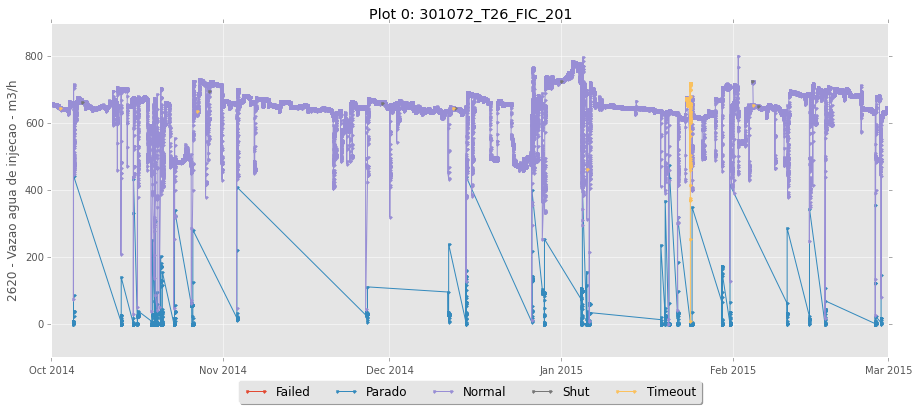

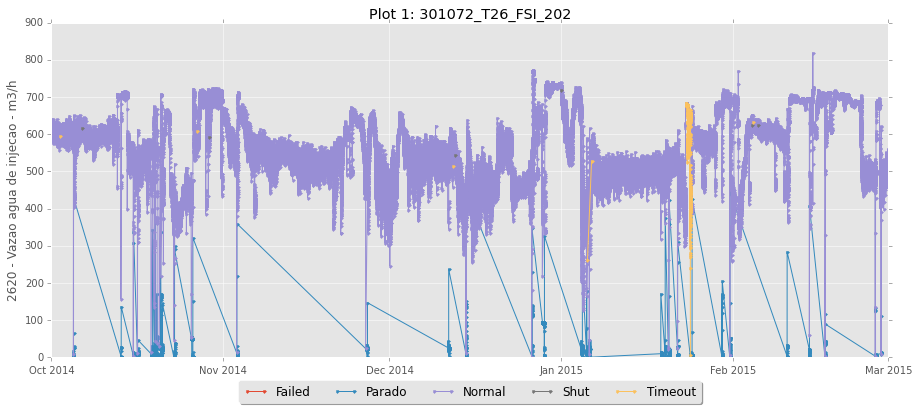

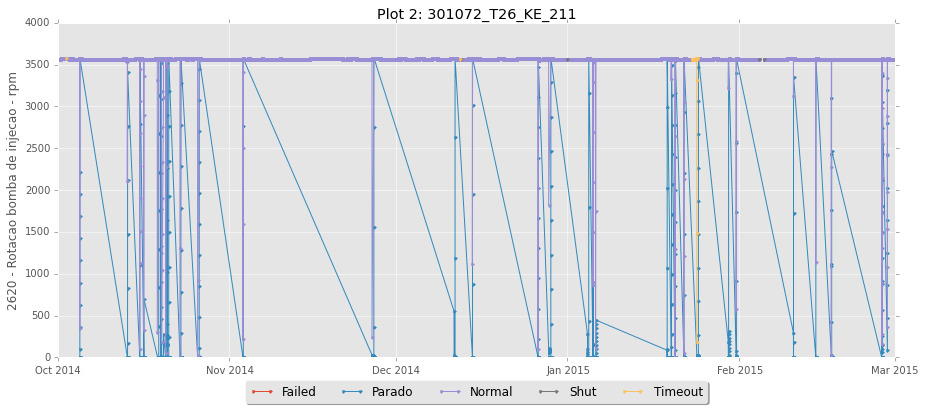

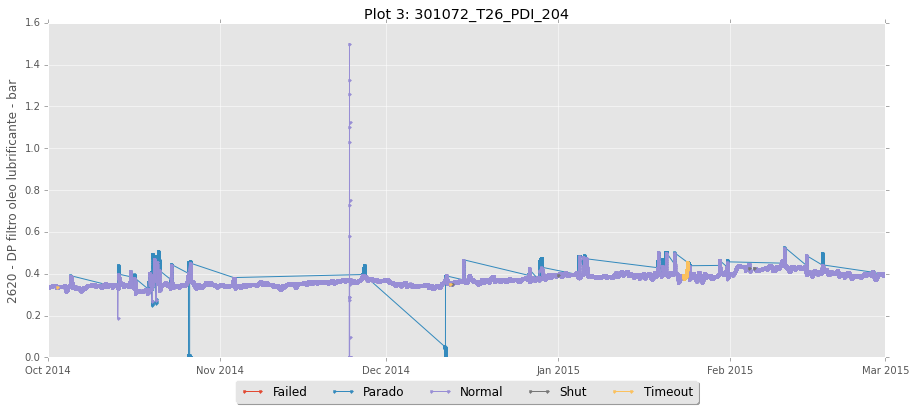

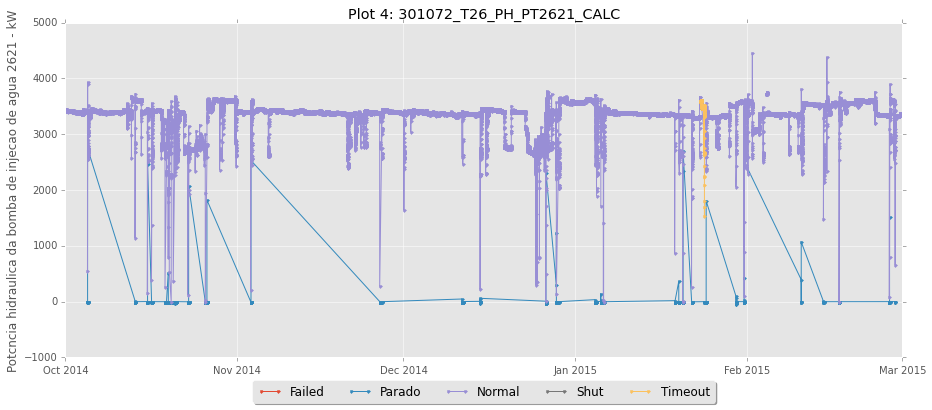

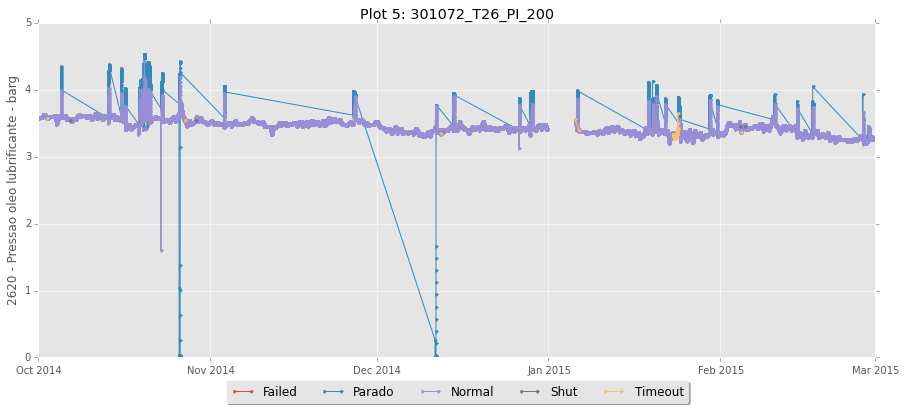

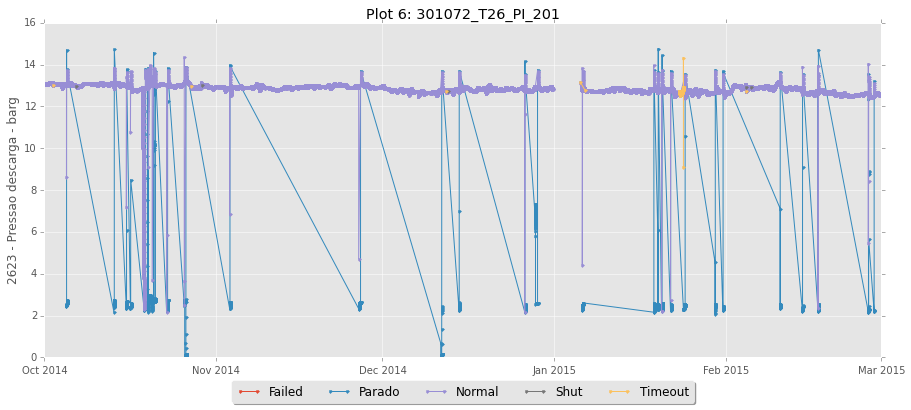

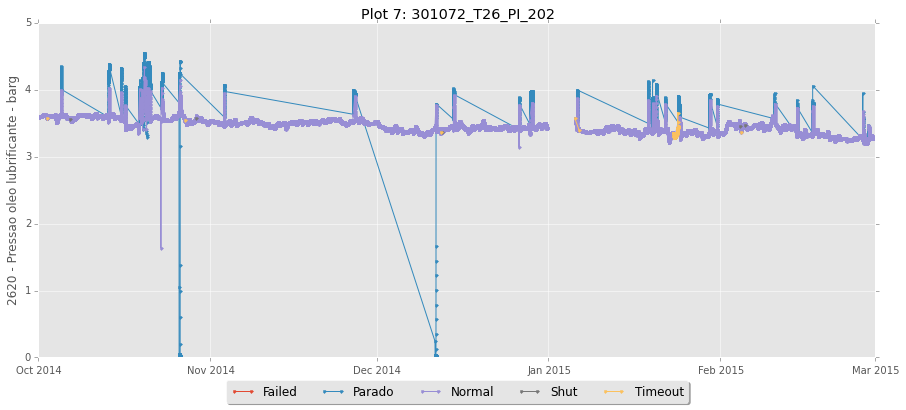

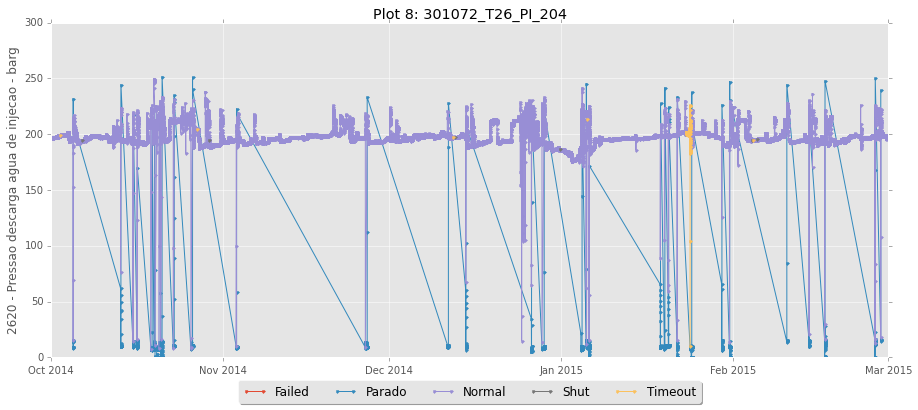

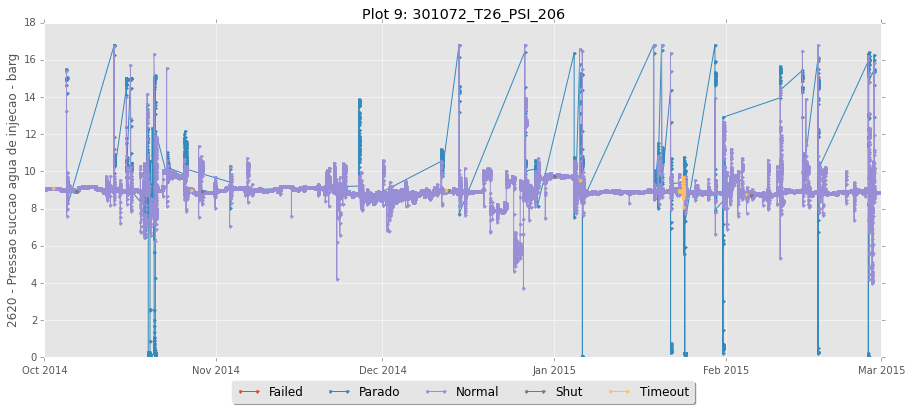

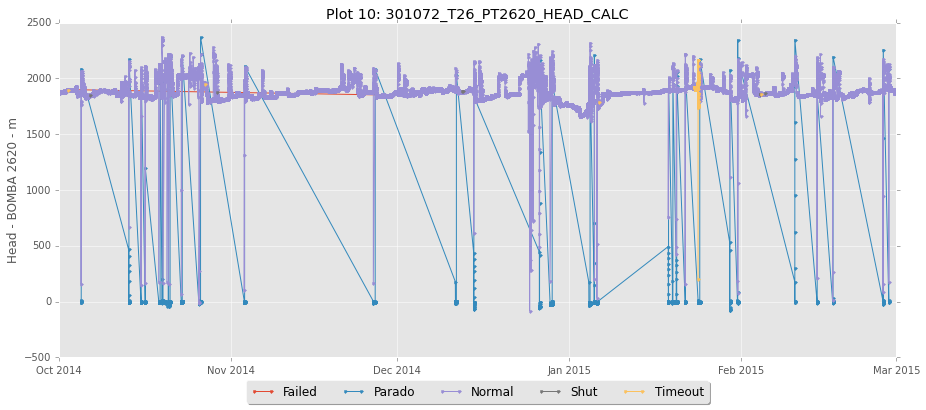

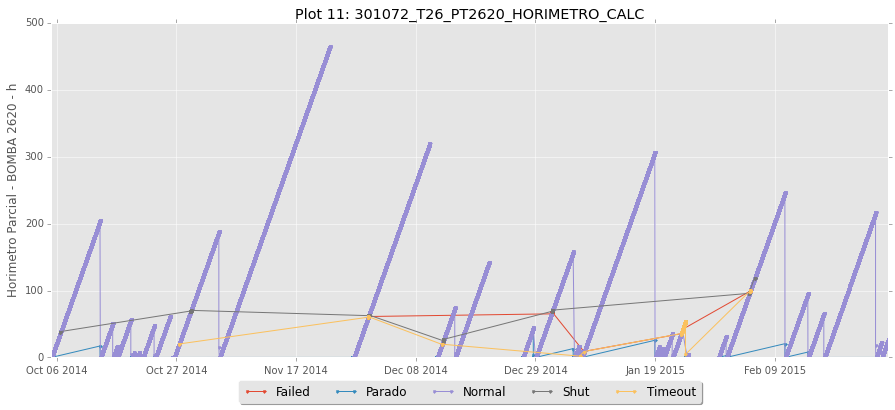

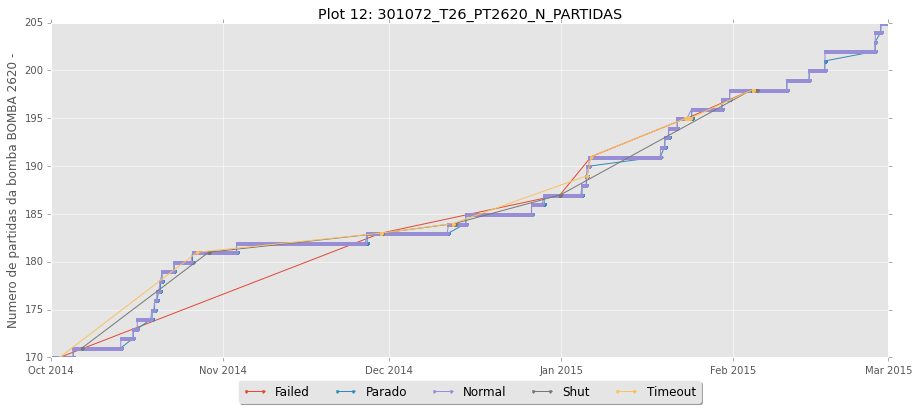

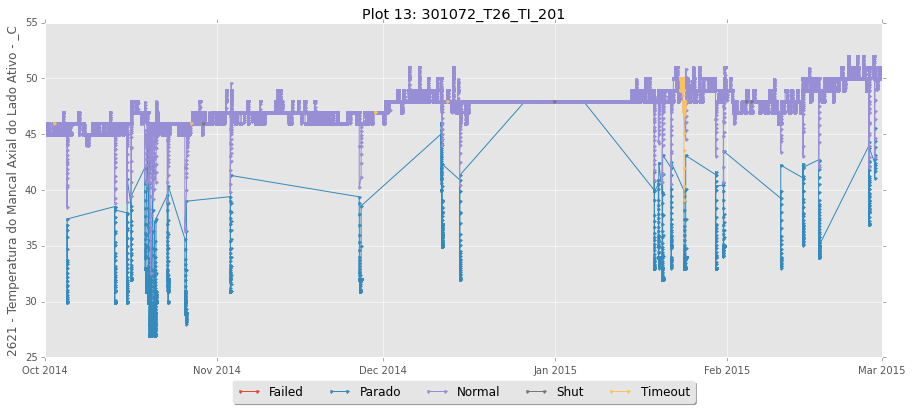

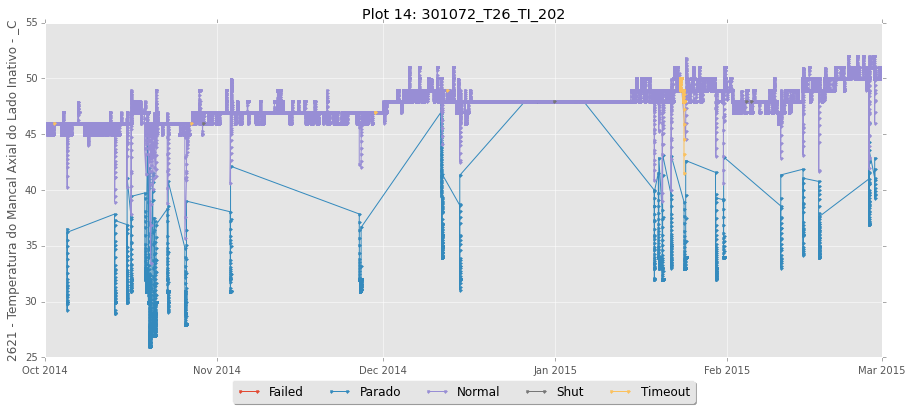

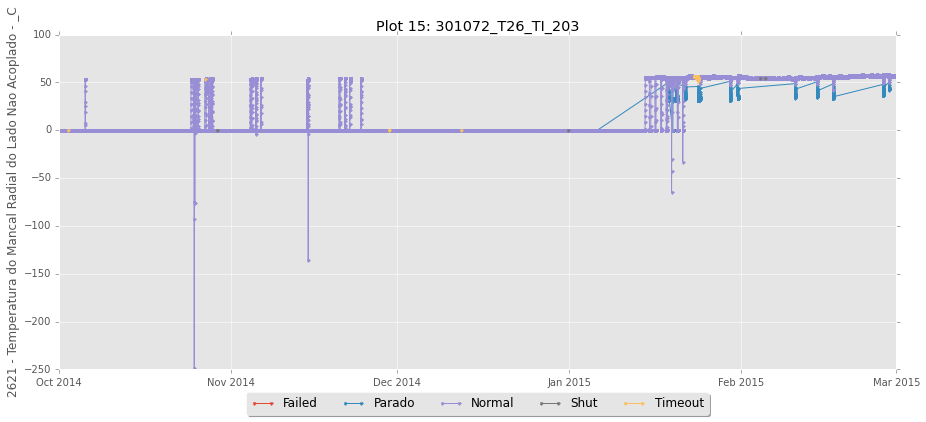

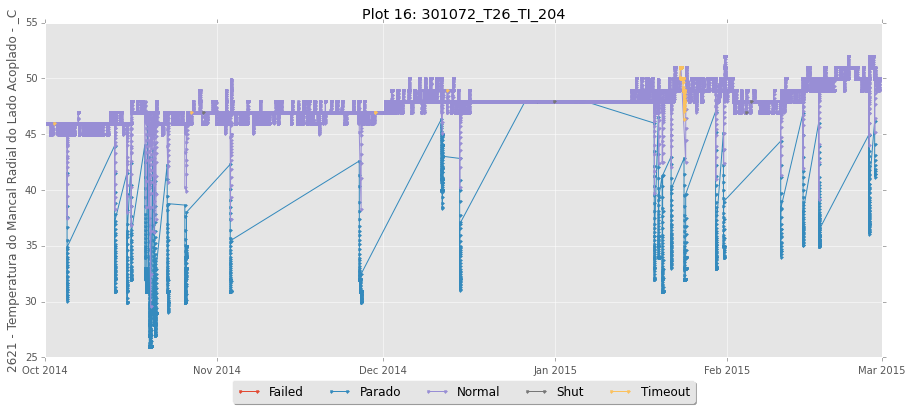

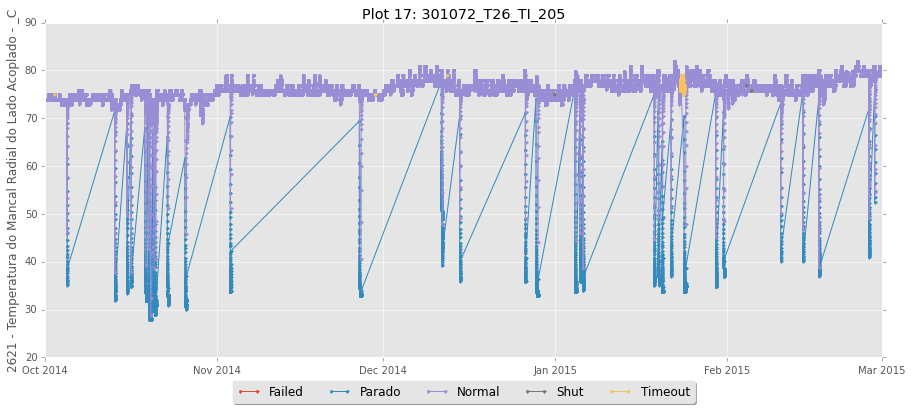

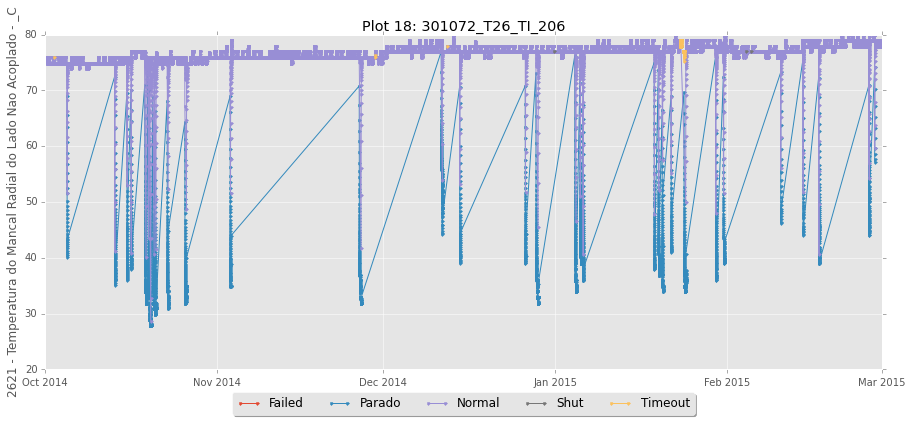

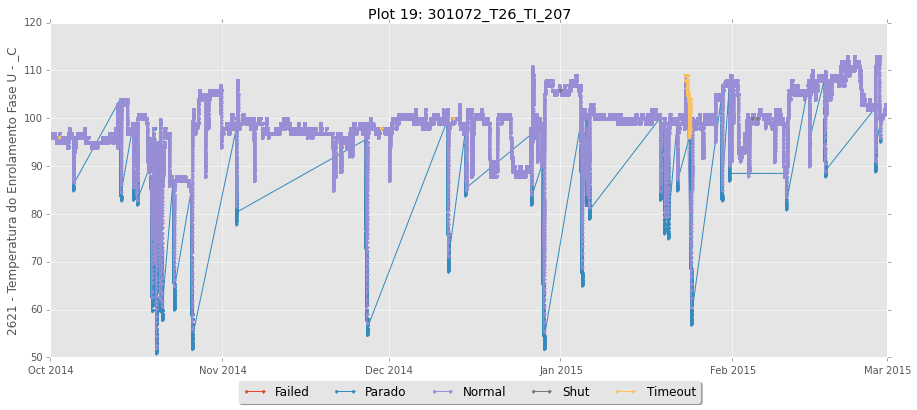

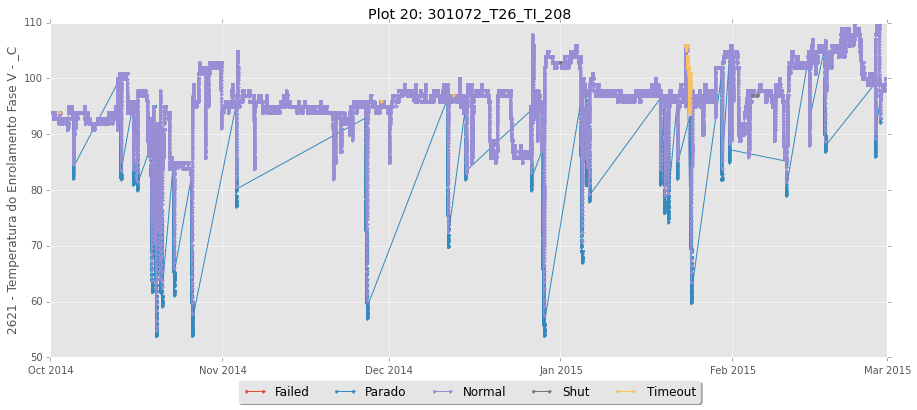

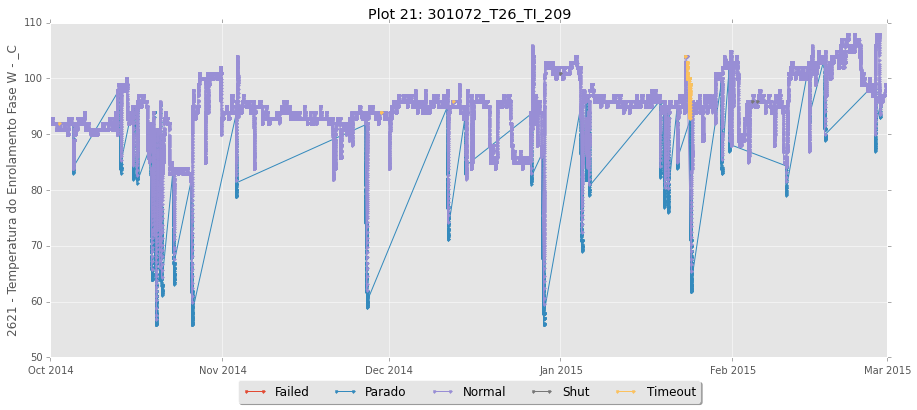

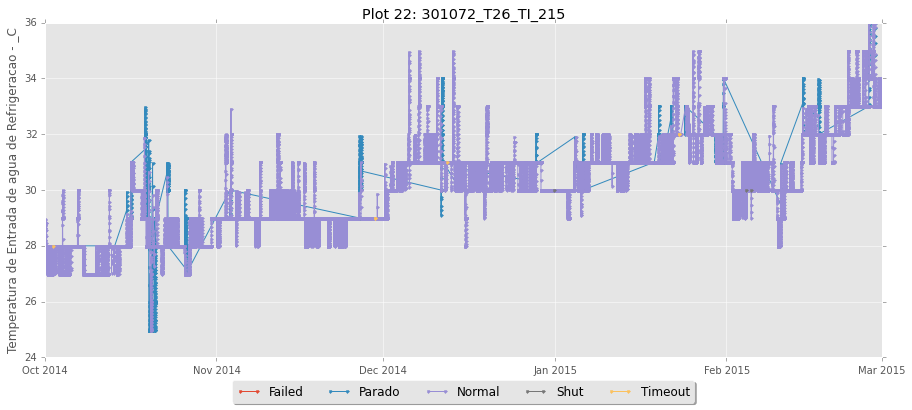

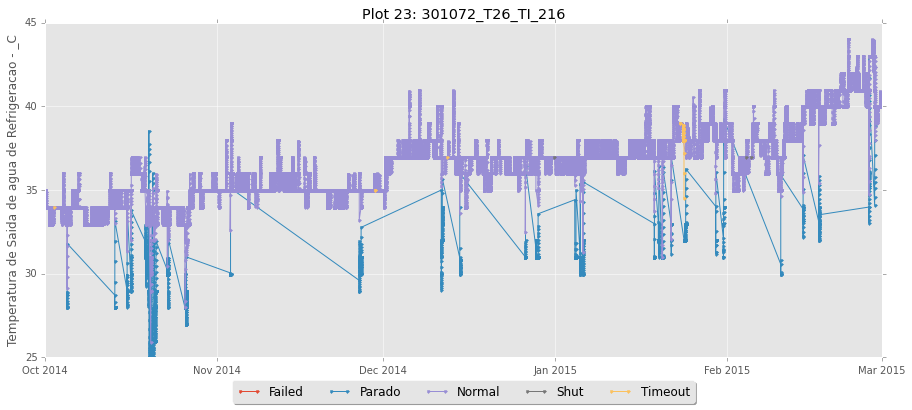

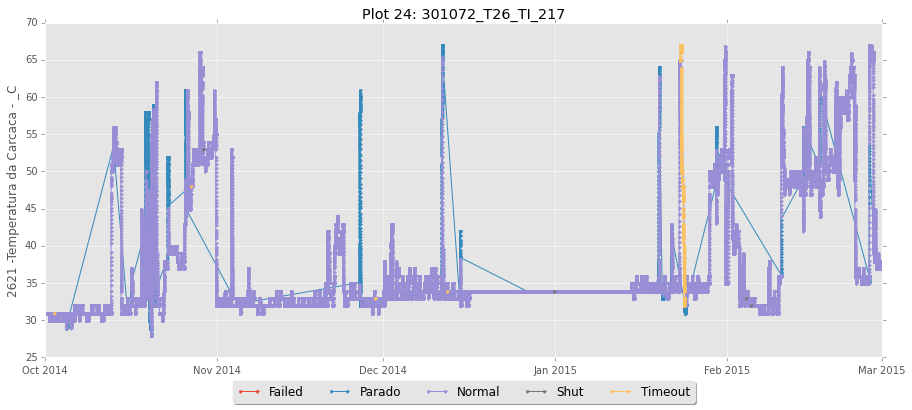

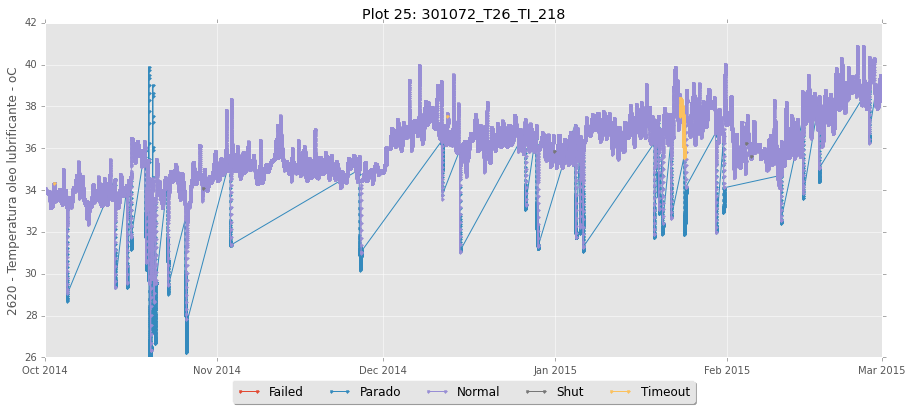

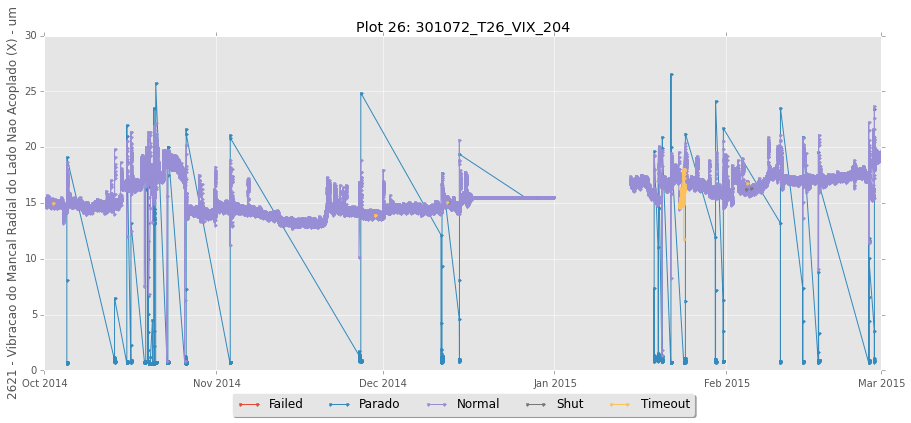

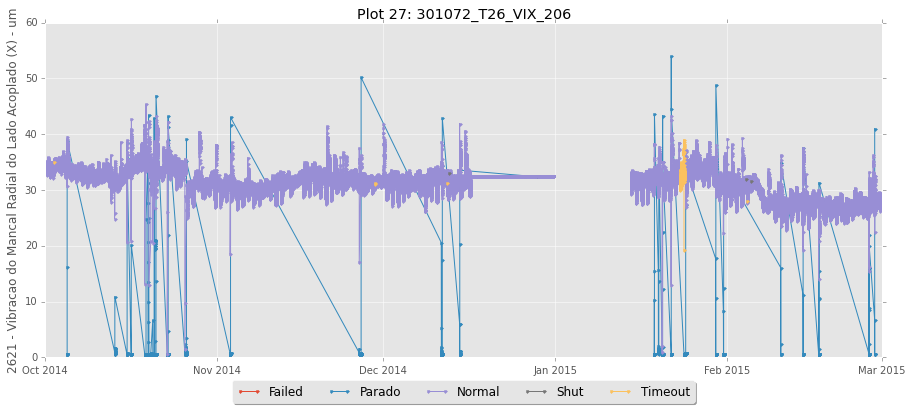

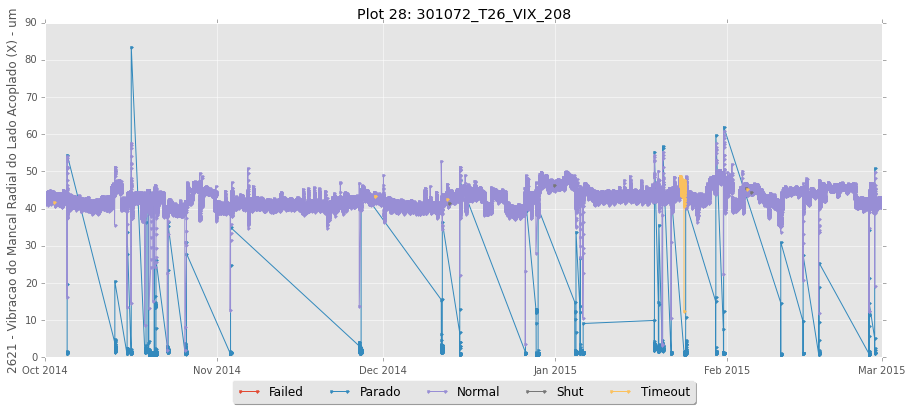

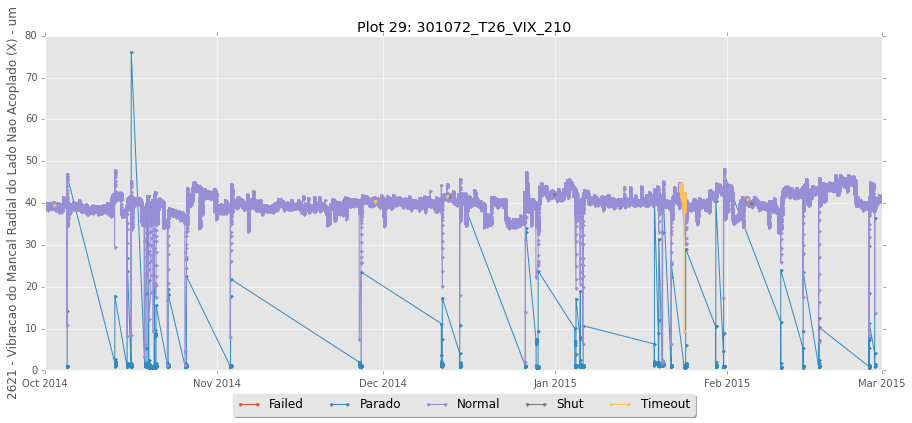

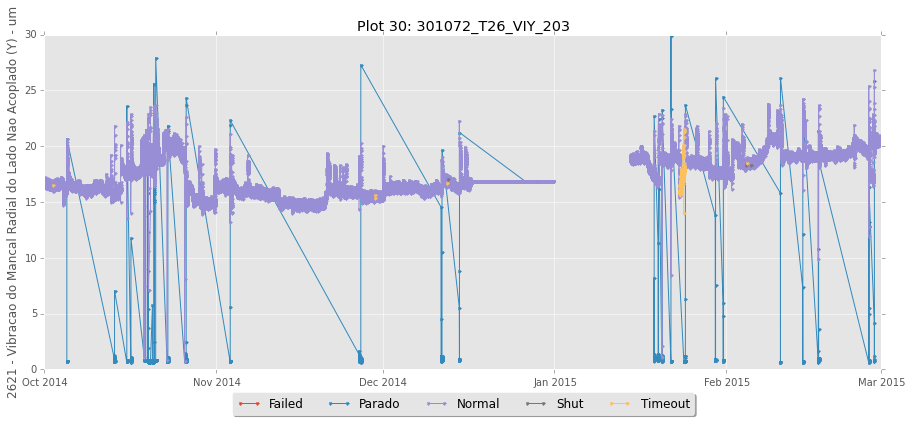

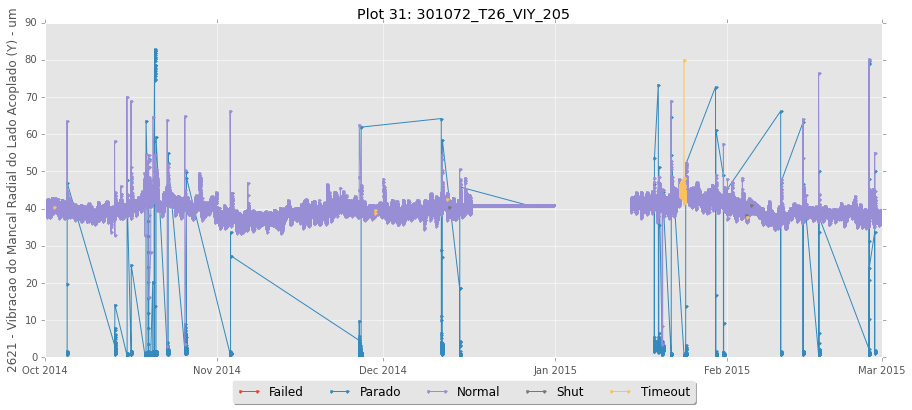

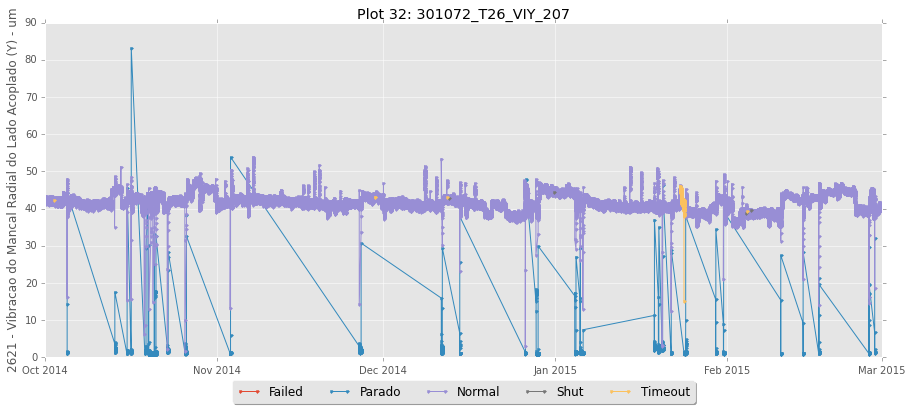

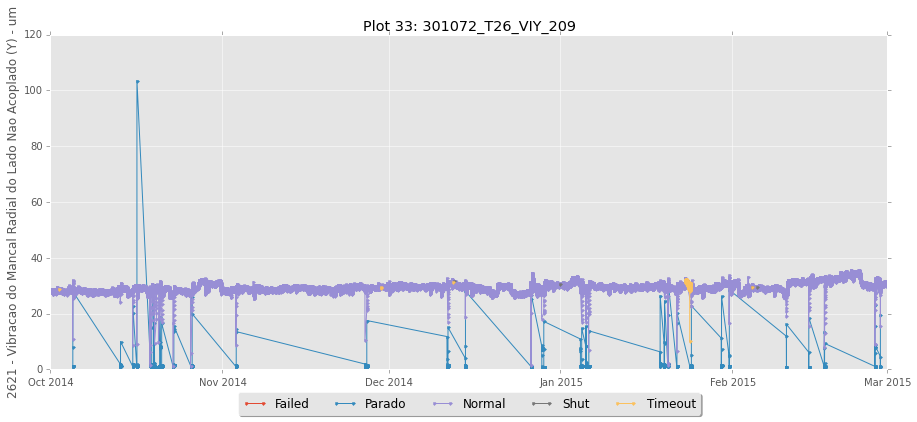

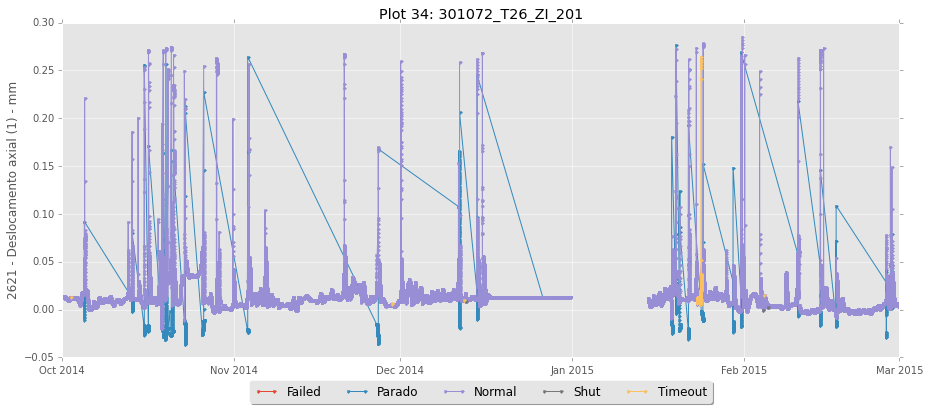

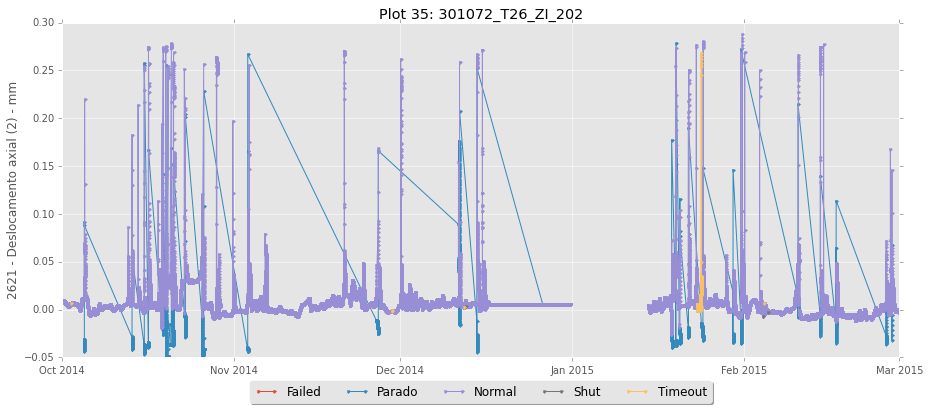

In [6]:
# Plot each numerical data color coded with categorical data
n_features = len(data_names)
for i in np.arange(n_features):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(15, 6))
    plt.plot(time_vector[failed_idx.values], data_frame.values[failed_idx.values, i], marker='.', label='Failed')
    plt.plot(time_vector[parado_idx.values], data_frame.values[parado_idx.values, i], marker='.', label='Parado')
    plt.plot(time_vector[normal_idx.values], data_frame.values[normal_idx.values, i], marker='.', label='Normal')
    plt.plot(time_vector[shut_idx.values], data_frame.values[shut_idx.values, i], marker='.', label='Shut')
    plt.plot(time_vector[timeout_idx.values], data_frame.values[timeout_idx.values, i], marker='.', label='Timeout')
    plt.title('Plot {}: {}'.format(i, data_names[i]))
    plt.ylabel('{} - {}'.format(data_descriptions[i], data_units[i]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    fig.show()

In [7]:
# Getting desired Variables
# desired_idxs = (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35)
desired_idxs = (0, 5, 6, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 28, 29, 32)
selected_data = data_frame.as_matrix(columns=None)[:, desired_idxs]
selected_names = data_names[[desired_idxs]]
selected_descriptions = data_descriptions[[desired_idxs]]
selected_units = data_units[[desired_idxs]]
selected_zero_span = data_zero_span[[desired_idxs]]
print 'Selected {} samples from {} variables'.format(selected_data.shape[0], selected_data.shape[1])

normal_data = selected_data[normal_idx.values, :]
normal_time = time_vector.values[normal_idx.values]
print 'Selected {} normal samples from {} variables'.format(normal_data.shape[0], normal_data.shape[1])

clean_data = normal_data[~np.isnan(normal_data).any(axis=1)]
clean_time = normal_time[~np.isnan(normal_data).any(axis=1)]
print 'Got {} clean normal samples from {} variables'.format(clean_data.shape[0], clean_data.shape[1])

Selected 217441 samples from 20 variables
Selected 209282 normal samples from 20 variables
Got 202119 clean normal samples from 20 variables


In [8]:
# Normalize Data
normalized_data = np.subtract(clean_data, [x[0] for x in selected_zero_span])
normalized_data = np.divide(normalized_data, [x[1] for x in selected_zero_span])

# Get desired delays
delays = [5, 10]
final_normalized_data = normalized_data
for delay in delays:
    b = np.roll(normalized_data, delay, axis=0)
    final_normalized_data = np.hstack((final_normalized_data, b))
final_normalized_data = final_normalized_data[np.max(delays):, :]
final_normalized_time = clean_time[np.max(delays):]
print 'Got final {} samples from {} variables.'.format(final_normalized_data.shape[0], final_normalized_data.shape[1])

Got final 202109 samples from 60 variables.


In [9]:
# Divide training and validation data
train_idx = np.where(final_normalized_time > np.datetime64('2015-01-01'))[0][0]
X_train = final_normalized_data[0:train_idx, :]
time_train = final_normalized_time[0:train_idx]
X_val = final_normalized_data[(train_idx + 1):, :]
time_val = final_normalized_time[(train_idx + 1):]

print 'Got {} training samples.'.format(X_train.shape[0])
print 'Got {} validation samples.'.format(X_val.shape[0])

Got 127241 training samples.
Got 74867 validation samples.


In [10]:
n_features = X_train.shape[1]
min_comp = 1
max_comp = 8
# Execute GridSearch
# This finds the best model for the selected data
# Set the parameters by cross-validation
param_grid = [{'n_components': np.arange(min_comp, max_comp + 1),
                     'n_pc' : np.arange(n_features - 1) + 1,
                     'verbose' : [0]}]

# Run grid search
grid_search = GridSearchCV(MPPCA(),
                           param_grid=param_grid,
                           scoring=MPPCA.sum_score,
                           verbose=2)
# model = MPPCA(n_components = 2, n_pc = 7, verbose = 2)
grid_start = time()
# model.fit(X_train)
grid_search.fit(X_train)
grid_end = time()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (grid_end - grid_start, len(grid_search.grid_scores_)))

grid_best = grid_search.best_estimator_
print 'The best found model was: '
print grid_best

Fitting 3 folds for each of 472 candidates, totalling 1416 fits
[CV] n_pc=1, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=1, n_components=1, verbose=0 -   2.1s
[CV] n_pc=1, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=1, n_components=1, verbose=0 -   1.9s
[CV] n_pc=1, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=1, n_components=1, verbose=0 -   1.9s
[CV] n_pc=2, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=2, n_components=1, verbose=0 -   1.9s
[CV] n_pc=2, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=2, n_components=1, verbose=0 -   1.9s
[CV] n_pc=2, n_components=1, verbose=0 ...............................
[CV] ...................... n_pc=2, n_components=1, verbose=0 -   2.2s
[CV] n_pc=3, n_components=1, verbose=0 ...............................
[CV] ........

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:  5.7min



[CV] n_pc=54, n_components=1, verbose=0 ..............................
[CV] ..................... n_pc=54, n_components=1, verbose=0 -   2.6s
[CV] n_pc=55, n_components=1, verbose=0 ..............................
[CV] ..................... n_pc=55, n_components=1, verbose=0 -   2.7s
[CV] n_pc=55, n_components=1, verbose=0 ..............................
[CV] ..................... n_pc=55, n_components=1, verbose=0 -   2.4s
[CV] n_pc=55, n_components=1, verbose=0 ..............................
[CV] ..................... n_pc=55, n_components=1, verbose=0 -   2.1s
[CV] n_pc=56, n_components=1, verbose=0 ..............................
[CV] ..................... n_pc=56, n_components=1, verbose=0 -   2.2s
[CV] n_pc=56, n_components=1, verbose=0 ..............................
[CV] ..................... n_pc=56, n_components=1, verbose=0 -   2.1s
[CV] n_pc=56, n_components=1, verbose=0 ..............................
[CV] ..................... n_pc=56, n_components=1, verbose=0 -   2.1s
[CV] 

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 36.3min
[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed: 110.2min



[CV] n_pc=39, n_components=4, verbose=0 ..............................
[CV] ..................... n_pc=39, n_components=4, verbose=0 -  14.8s
[CV] n_pc=40, n_components=4, verbose=0 ..............................
[CV] ..................... n_pc=40, n_components=4, verbose=0 -  12.1s
[CV] n_pc=40, n_components=4, verbose=0 ..............................
[CV] ..................... n_pc=40, n_components=4, verbose=0 -  17.9s
[CV] n_pc=40, n_components=4, verbose=0 ..............................
[CV] ..................... n_pc=40, n_components=4, verbose=0 -  10.7s
[CV] n_pc=41, n_components=4, verbose=0 ..............................
[CV] ..................... n_pc=41, n_components=4, verbose=0 -  12.2s
[CV] n_pc=41, n_components=4, verbose=0 ..............................
[CV] ..................... n_pc=41, n_components=4, verbose=0 -  17.5s
[CV] n_pc=41, n_components=4, verbose=0 ..............................
[CV] ..................... n_pc=41, n_components=4, verbose=0 -  12.4s
[CV] 

[Parallel(n_jobs=1)]: Done 1012 tasks       | elapsed: 200.4min
[Parallel(n_jobs=1)]: Done 1416 out of 1416 | elapsed: 327.3min finished



GridSearchCV took 19664.27 seconds for 472 candidate parameter settings.
The best found model was: 
MPPCA(init_params='wmpn', min_covar=0.001, n_components=7, n_init=1,
   n_iter=100, n_pc=9, params='wmpn', random_state=None, tol=0.001,
   verbose=0)


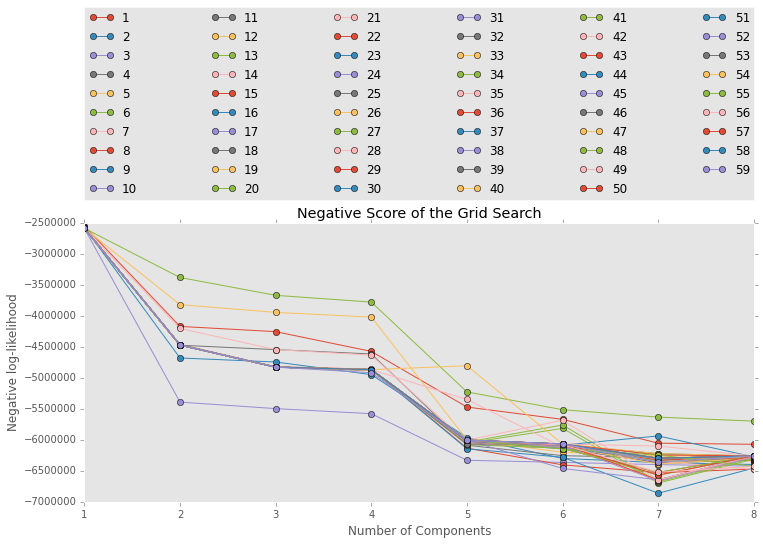

In [11]:
# Score analysis for the trained models        
grid_scores = grid_search.grid_scores_
# Analyse models based on the validation data set
num_comps = np.arange(min_comp, max_comp + 1)
n_pcs = np.arange(n_features - 1) + 1
grid_search_neg_sum_loglike = np.zeros((len(num_comps), len(n_pcs)))

for score in grid_scores:
    n_pc_idx = score.parameters.get('n_pc') - 1
    n_comp_idx = score.parameters.get('n_components') - 1
    grid_search_neg_sum_loglike[n_comp_idx, n_pc_idx] = -score.mean_validation_score
        
plt.figure(figsize=(12, 5))
plt.plot(num_comps, grid_search_neg_sum_loglike, marker='o')
plt.legend(n_pcs, bbox_to_anchor=(0., 1.08, 1., .102), loc=3,
           ncol=6, mode="expand", borderaxespad=0.)
plt.title('Negative Score of the Grid Search')
plt.ylabel('Negative log-likelihood')
plt.xlabel('Number of Components')
plt.grid()
plt.show()

The threshold via Monte Carlo is -194.000654967


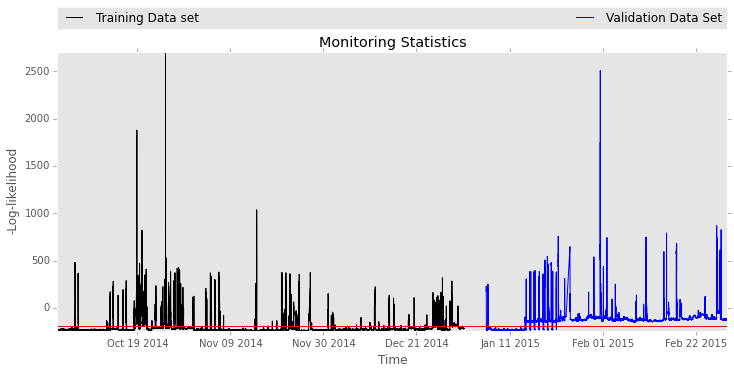

9398 samples from training data is out of control. That represents 7.38598407746 of the data.
60648 samples from validation data is out of control. That represents 81.0076535723 of the data.


In [12]:
best_model = grid_best
# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = best_model.sample(N_sample)
logprob_sample, responsability_sample = best_model.score_samples(best_model_sample)
sorted_logprob_sample = np.sort(logprob_sample)
threshold = sorted_logprob_sample[int(np.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = best_model.score_samples(X_train)
logprob_val, responsability_val = best_model.score_samples(X_val)

plt.figure(figsize=(12, 5))
plt.plot(time_train, -logprob_train, color = 'black')
plt.plot(time_val, -logprob_val, color = 'blue')
plt.plot((time_train[0], time_val[-1]), (-threshold, -threshold), color = 'red')
plt.axis('tight')
plt.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.08, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Monitoring Statistics')
plt.ylabel('-Log-likelihood')
plt.xlabel('Time')
plt.grid()
plt.show()
out_train = np.sum(-logprob_train > -threshold)
print '{} samples from training data is out of control. That represents {} of the data.'.format(out_train, float(out_train)/float(len(logprob_train))*100)
out_val = np.sum(-logprob_val > -threshold)
print '{} samples from validation data is out of control. That represents {} of the data.'.format(out_val, float(out_val)/float(len(logprob_val))*100)

Got final 207328 samples from 60 variables.


[None, None, None, None, None, None]

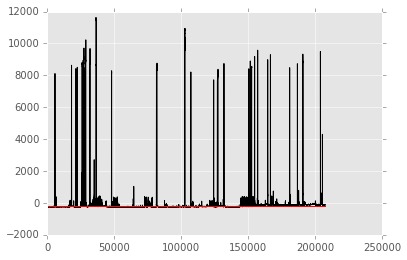

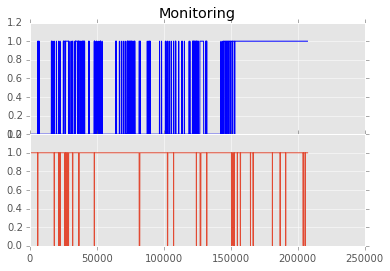

In [13]:
# Window analysis
# Normalize Data
clean_data_to_monitor = selected_data[~np.isnan(selected_data).any(axis=1), :]
data_to_monitor = np.subtract(clean_data_to_monitor, [x[0] for x in selected_zero_span])
data_to_monitor = np.divide(data_to_monitor, [x[1] for x in selected_zero_span])

# Get desired delays
final_data_to_monitor = data_to_monitor
for delay in delays:
    b = np.roll(data_to_monitor, delay, axis=0)
    final_data_to_monitor = np.hstack((final_data_to_monitor, b))
final_data_to_monitor = final_data_to_monitor[np.max(delays):, :]
print 'Got final {} samples from {} variables.'.format(final_data_to_monitor.shape[0], final_data_to_monitor.shape[1])

n, d = final_data_to_monitor.shape
windows_size = 100

monitoring_status = np.zeros(n - windows_size + 1)
for i in np.arange(n-windows_size+1):
    window = final_data_to_monitor[i:(i+windows_size), :]
    window_logprob, window_responsability = best_model.score_samples(window)
    monitoring_status[i] = np.sum(-window_logprob > -threshold) > np.round((1-0.999)*windows_size)

data_to_monitor_logprob, data_to_monitor_responsability = best_model.score_samples(final_data_to_monitor)

plt.figure()
plt.plot(-data_to_monitor_logprob, color = 'black')
plt.plot((1, len(final_data_to_monitor)), (-threshold, -threshold), color = 'red')
plt.figure()
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(monitoring_status, color='blue')
ax1.set_title('Monitoring')
ax2.plot(normal_idx.values[~np.isnan(selected_data).any(axis=1)])
plt.ylim((0, 1.2))
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)